# ネットワーク解析のガイド (パート 2 - ルートの検索)

## 目次
- [イントロダクション](#イントロダクション)
- [問題文](#問題文)
- [データ](#データ)
    - [ストップ フィーチャ クラスへのアクセス](#ストップ-フィーチャ-クラスへのアクセス)
    - [ストップの順番の並びかえ](#ストップの順番の並びかえ)
- [メソッド](#メソッド)
    - [メソッド 1 - arcgis.network.analysis.find_routes を使う](#メソッド-1---arcgis.network.analysis.find_routes-を使う)
        - [find_routes の結果をテーブル化する](#find_routes-の結果をテーブル化する)
        - [find_routes の結果を可視化する](#find_routes-の結果を可視化する)
    - [メソッド 2 - arcgis.features.use_proximity.plan_routes を使う](#メソッド-2---arcgis.features.use_proximity.plan_routes-を使う)
    
        - [入力パラメーターの準備](#入力パラメーターの準備)
        - [output_name を指定した場合](#output_name-を指定した場合)
        - [output_name を指定しなかった場合](#output_name-を指定しなかった場合)
- [次のトピックについて](#次のトピックについて)
- [参考](#参考)

## イントロダクション
いま、私達はネットワーク データセットのコンセプト及びネットワーク解析サービスについて学びました。2 つ目のトピックに移りましょう。ここでは、「どのようにして、ある地点から別の地点へのルートを検索するのか」、「複数の地点間の場合はどのようにルートを検索するのか」について紹介します。これは次のような問題を解決します。

- ポイント A からポイント B への最も速いルートはどれか？
- ポイント A、B、C、D 間を移動するために最も短いルートはどれか？

前回のトピックを再確認したい場合や、次のトピックにスキップしたい場合は以下のロード マップを参照してください。

 - Network Dataset and Network Analysis (<a href="part1_introduction_to_network_analysis.ipynb">You are here!</a>) / ネットワーク データセットとネットワーク解析 (<a href="part1_introduction_to_network_analysis_ja.ipynb">パート 1</a>)
 - Find Routes (<a href="part2_find_routes.ipynb">Part 2</a>) / ルート検索 (この翻訳版)
 - Generate Service Area (<a href="part3_generate_service_area.ipynb">Part 3</a>) / 到達圏の作成 (パート 3)
 - Find Closest Facility (<a href="part4_find_closest_facilities.ipynb">Part 4</a>) / 最寄りの検索
 - Generate Origin Destination Cost Matrix (<a href="part5_generate_od_cost_matrix.ipynb">Part 5</a>) / OD コストマトリックス
 - Solve Location Allocation (<a href="part6_solve_location_allocation.ipynb">Part 6</a>) / ロケーション・アロケーション
 - Vehicle Routing Problem Service (<a href="part7_vehicle_routing_problem.ipynb">Part 7</a>) / 配車ルート解析

ルートは、ストップやポイントの地点を最速もしくは最短で訪れる道路に沿ったパスを表します。これらは、指定した順番でポイントからポイントを移動する基本的なルート、もしくは全体の移動時間や距離を最小化した順番のルートを解析することができます。ルートはローカルのネットワーク データセットか、ArcGIS Online や ArcGIS Enterprise でホストされたネットワーク サービスに基づいています <a href="#参考">[1]</a>。ここでは、ルートの検索を行うために、ArcGIS Online のサービスをどのように利用するかを紹介します。

## 問題文
複数のポイント間のルートをどのようにして見つけるのかということを中心に考えると、具体的なユーザーのストーリーは次のようなものでしょう。

ジムは夏のアメリカ合衆国西部の旅行を計画しています。彼はマイアミからスタートし、サンフランシスコで旅を終えることを決めました。さらに、サンノゼ、ロサンゼルス、サンディエゴ、フェニックス、エルパソ、ヒューストン、ニューオーリンズ、オーランドの 8 都市に途中立ち寄ることにしました。ジムがこれらの 10 都市を、途中その他の地点に立ち寄ることなく、旅行するために最も良いルートはどのようなものになるでしょうか？そして、移動距離と移動時間の推計はどのくらいでしょうか？最後に、ジムにルートの方角と地図を提供することはできるでしょうか？

いま、ジムの目的が明確になったので、問題をブレイク ダウンしましょう
 - データ: 入力するデータセットはどこから取得するか
 - 方法: ネットワーク モデルを構築し、ルート解析を行うために利用できるツールは何があるか
 - テーブルとマップ: 方角とルートが可視化された成果物はどのようなものか

それでは、最初に、入力するデータセットを探しましょう（今回の場合、ストップとなるフィーチャ クラスです）。

## データ

### ストップ フィーチャ クラスへのアクセス

`find_routes` ツールは入力パラメーターとして`ストップ フィーチャ セット`を必要とします。これは、2 つ以上のストップを指定する必要があると同時に、上限は10,000 ストップ、または 1 つのルートに対して 150 ストップです。

この例では、既存のフィーチャ サービスから `stops` を抽出します。まずはじめに、必要なモジュールを全てインポートします。そして目的の組織に対して GIS オブジェクトを作成します。

In [1]:
from copy import deepcopy
import datetime as dt
from IPython.display import HTML
import json
import pandas as pd
from arcgis.gis import GIS
import arcgis.network as network
import arcgis.geocoding as geocoding
from arcgis.features import FeatureLayer, FeatureSet, FeatureCollection
import arcgis.features.use_proximity as use_proximity

もし、ArcGIS Onlineの組織に対して既にプロファイルを設定 (訳注：認証情報をローカルのコンピューターに保存しておくことができます。詳細は[認証に係るガイド](https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/#Storing-your-credentials-locally)を参照ください) していれば以下のセルを実行してプロファイルをロードして GIS クラスのオブジェクトを作成してください。
もし設定していなければ、ユーザー名、パスワードを用いてログインしてください。例：`my_gis = GIS('https://www.arcgis.com', 'arcgis_python', 'P@ssword123', verify_cert=False, set_active=True)`

In [3]:
my_gis = GIS(profile="your_online_profile")

使用するフィーチャ レイヤーは「USA Major Cities」というタイトルで、search メソッドを使ってアクセスできます。

<Item title:"USA Major Cities" type:Feature Layer Collection owner:esri_dm>
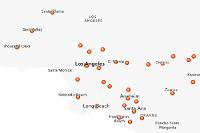

In [5]:
sample_cities = my_gis.content.search('title:"USA Major Cities" type:Feature Service owner:esri*',
                                      outside_org=True)[0]
sample_cities

訪問する都市をリストに配置し、後でリストを文字列に整形するために使用されるフォーマッタを作成します。

In [6]:
stops_cities = ['San Francisco', 'San Jose', 'Los Angeles', 'San Diego',
                'Phoenix', 'El Paso', 
                'Houston', 'New Orleans', 'Orlando', 'Miami']
values = "'" + "', '".join(stops_cities) + "'"

In [7]:
stops_cities_fl = FeatureLayer(sample_cities.url + "/0")
type(stops_cities_fl)

arcgis.features.layer.FeatureLayer

`FeatureLayer` クラスのオブジェクトを作成し、`query` メソッドを呼び出し、FeatureSet として各都市を取得します。

In [8]:
stops_cities_fset = stops_cities_fl.query(where="ST in ('CA', 'NV', 'TX', 'AZ', 'LA', 'FL')  AND NAME IN ({0})".format(values), as_df=False)
stops_cities_fset

<FeatureSet> 10 features

In [9]:
start_cities_fset = stops_cities_fl.query(where="ST='FL' AND NAME = 'Miami'", as_df=False)
start_cities_fset

<FeatureSet> 1 features

### ストップの順番の並びかえ

`FeatureLayer.query()` メソッドから返された FeatureSet に含まれるフィーチャが、検索文字列の順序と一致しないことがあります。例えば、`stop_cities` の開始地点は "San Francisico" ですが、返されたFeatureSet の `stops_cities_fset` では "Los Angeles" が開始地点のようになっています。

In [10]:
print(list(map(lambda x: x.attributes['NAME'], stops_cities_fset)))

['Los Angeles', 'San Diego', 'San Francisco', 'San Jose', 'Phoenix', 'New Orleans', 'Miami', 'Orlando', 'El Paso', 'Houston']


FeatureSet 内のストップを並べ替えることができる `re_order_stop_cities` 関数を以下のように定義します。

In [11]:
""" 任意の順序にストップを並べ替える関数を定義
"""
def re_order_stop_cities(fset=stops_cities_fset, start_city = "Miami", end_city = "San Francisco"):
    
    stops_cities_flist = []
    last_city = None

    for ea in fset:
        if ea.attributes['NAME'] == start_city:
            stops_cities_flist.insert(0, ea)
        elif ea.attributes['NAME'] == end_city:
            last_city = ea
        else:
            stops_cities_flist.append(ea)
    stops_cities_flist.append(last_city)
 
    return FeatureSet(stops_cities_flist)

In [12]:
re_ordered_stops_cities_fset = re_order_stop_cities()
re_ordered_stops_cities_fset

<FeatureSet> 10 features

並べ替えた FeatureSet には `spatialReference` を定義する必要があります。定義しなかった場合、解析時に `Invalid value for parameter Stops - Details : Invalid JSON for GPFeatureRecordSetLayer or GPRecordSet datatype Failed.` というエラーが発生します。

In [13]:
re_ordered_stops_cities_fset.spatial_reference = stops_cities_fset.spatial_reference

In [14]:
re_ordered_stops_cities = list(map(lambda x: x.attributes['NAME'], re_ordered_stops_cities_fset))
print(re_ordered_stops_cities)

['Miami', 'Los Angeles', 'San Diego', 'San Jose', 'Phoenix', 'New Orleans', 'Orlando', 'El Paso', 'Houston', 'San Francisco']


## メソッド

ArcGIS API for Python はルート解析の方法として、**RouteLayer.solve**、**find_routes**、**plan_routes** の 3 つのメソッドを提供しています。

| 解析の種類 |  network.analysis | features.use_proximity |
|:-----------------|:-------------------------|:------------------------|
| Route （ルート検索） |  **find_routes**        | **plan_routes**        |
| ServiceArea （到達圏） |  generate_service_areas | create_drive_time_areas|
| ClosestFacility（最寄りの検索）|  find_closest_facilities| find_nearest |

これら 3 つのメソッドは異なるモジュールで定義されており、裏側では異なる REST API を呼び出しています。**RouteLayer.solve** と **network.analysis.find_routes**、**features.use_proximity.plan_routes** の主な違いは、RouteLayer.solve は独自もしくは高度なネットワーク解析のワークフローを想定しており、独自のネットワーク解析レイヤーを公開する必要があります。network.analysis.find_routes、features.use_proximity.plan_routes は、ArcGIS Online 上でホストされているルート検索 サービスに対して動作します。プロキシ サービスを介して ArcGIS Enterprise 上で利用することもできます。利用にはクレジット消費が必要となります。

このパートでは、同一の問題を `network.analysis.find_routes()` と `features.use_proximity.plan_routes()` で解析し、それらのワークフローについて `stops_cities` で定義された 10 都市間を移動するための最短ルートを設計して説明します。そして、それらのプロセスの違いを探っていきます。

### メソッド 1 - arcgis.network.analysis.find_routes を使う

ルート検索では、複数地点間を移動するための最速または最短の経路を決定することができます。複数のストップを訪問したり、場所間の距離や移動時間を測定したりするために、`arcgis.network.analytics` モジュールの `find_routes` ツールを使用するとよいでしょう。このツールは実行するたびに1台以上の車両のルートを見つけることができるので、複数のドライバーが事前に指定したストップに移動するための最適なルートを決定することができます。`find_routes`のパラメーターは次のものを含んでいます：
- `stops`: 必須パラメーター。２つ以上のストップを指定します。
- `preserve_terminal_stops`: 末端のストップを維持 (str 型)。オプションパラメーター。 最適なルートを見つけるためreorder_stops_to_find パラメーターが True の場合、始点または終点を保存できます。そしてツールは残りのストップを並べ替えます。
- `time_of_day`: 時刻 (datetime 型)。オプションパラメーター。ルートの移動を開始する時間と日付を指定。
- `time_zone_for_time_of_day`: 時刻のタイム ゾーン (str 型)。オプションパラメーター。time_of_day パラメーターのタイム ゾーンを指定します。
- もし出力のルートを新しいレイヤー ファイルに保存したい場合、`save_output_na_layer` を True に設定します。


In [17]:
%%time

start_time = int(dt.datetime.now().timestamp() * 1000)

result = network.analysis.find_routes(re_ordered_stops_cities_fset, time_of_day=start_time, 
                                      time_zone_for_time_of_day="UTC",
                                      preserve_terminal_stops="Preserve None",
                                      reorder_stops_to_find_optimal_routes=True,
                                      save_output_na_layer=True)

WARNING 030194: Data values longer than 500 characters for field [Stops:Name] are truncated.
Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").


Wall time: 1min 2s


続いて、ツールが正常に動作したかどうか、各出力要素の種類は何か、そして出力ルートのネットワーク解析レイヤーのURLは何かを確認してみましょう。

In [18]:
print("ツールは正常に実行されたか？", result.solve_succeeded)

ツールは正常に実行されたか？ True


前の操作で得られた結果は、output_routes、output_stops、output_directionsの3つのコンポーネントとして ToolOutput に含まれています。

In [19]:
type(result)

arcgis.geoprocessing._support.ToolOutput

In [20]:
result.output_routes, result.output_stops, result.output_directions

(<FeatureSet> 1 features, <FeatureSet> 10 features, <FeatureSet> 261 features)

In [21]:
result.output_network_analysis_layer.url

'https://logistics.arcgis.com/arcgis/rest/directories/arcgisjobs/world/route_gpserver/j4b5569ebe7bd4b5ba4b4d39c55895190/scratch/_ags_gpna077210131be5408292a81366e8b8d950.lyr'

#### find_routes の結果をテーブル化する

結果の `output_directions` は、Pandas のデータフレーム(ルート上のすべての方向をリストアップしたもの)として読み込むことができます。

In [24]:
""" 出力結果の方向にアクセスする
"""
df = result.output_directions.sdf
df = df[["RouteName", "ArriveTime", "DriveDistance", "ElapsedTime", "Text"]].loc[df["RouteName"] == "Miami - San Francisco"]
df.head()

,RouteName,ArriveTime,DriveDistance,ElapsedTime,Text
0,Miami - San Francisco,2020-06-23 21:31:23.506999969,0.000000,0.000000,Start at Miami
1,Miami - San Francisco,2020-06-23 21:31:23.506999969,0.089587,0.369263,Go west on SW 13th St toward SW 17th Ave
2,Miami - San Francisco,2020-06-23 21:31:45.663000107,1.043712,2.387372,Turn left on SW 17th Ave
3,Miami - San Francisco,2020-06-23 21:34:07.371000051,0.616441,0.876218,Make a sharp left on S Dixie Hwy (US-1 N)
4,Miami - San Francisco,2020-06-23 21:35:01.477999926,3.317971,4.579577,Keep left at the fork onto I-95 N


In [25]:
df.tail()

,RouteName,ArriveTime,DriveDistance,ElapsedTime,Text
256,Miami - San Francisco,2020-06-25 20:28:01.177000046,0.040609,0.156849,Continue forward on Masonic Ave
257,Miami - San Francisco,2020-06-25 20:28:10.588000059,0.059725,0.258612,Make a sharp right on Upper Ter
258,Miami - San Francisco,2020-06-25 20:28:26.105000019,0.067130,0.577511,Bear left
259,Miami - San Francisco,2020-06-25 20:28:26.105000019,0.000000,0.000000,Restriction: Through Traffic Prohibited
260,Miami - San Francisco,2020-06-25 20:29:00.755000114,0.000000,0.000000,"Finish at San Francisco, on the left"


また、返却されたオブジェクトの `output_routes` コンポーネントから、移動全体のサマリーテーブルを作成することができます。

In [26]:
""" アウトプットのルートにアクセス
"""
df = result.output_routes.sdf
start_times = pd.to_datetime(df["StartTime"], unit="ms")
end_times = pd.to_datetime(df["EndTime"], unit="ms")
df["StartTime"] = start_times.apply(lambda x: x.strftime("%H:%M:%S"))
df["EndTime"] = end_times.apply(lambda x: x.strftime("%H:%M:%S"))
df[["Name", "StartTime", "EndTime", "StopCount", "Total_Kilometers", "Total_Minutes"]]

,Name,StartTime,EndTime,StopCount,Total_Kilometers,Total_Minutes
0,Miami - San Francisco,21:31:23,20:29:00,10,5272.401666,2997.620807


上記の結果から、マイアミからサンフランシスコまでの推定移動距離は約 5272.401 kmで、推定移動時間は 2997.620 分 (約 49.960 時間) であるということがわかります。これは、例えば、もしマイアミを月曜日の 21:31:23 PM (EST) に出発したら、サンフランシスコに水曜日の 20:29:00 PM (PST) に到着することが期待できることを意味します。

#### find_routes の結果を可視化する

これで私達は旅行のプランを完全にマスターしました。次はマップ ウィジェットにルートを可視化しましょう。これでユーザーはストップ間の地理的な地理的な関係をよりよく把握することができます。

以下のセルでは、ストップとルートのスタイルやシンボルを定義しています。始点と終点は強調するために、シンボルとして吹き出しのアイコンを割り当てます。

In [69]:
""" 描画用にカスタマイズするスタイル、シンボル、ポップアップ
"""
styles = [    
    dict(selector="td", props=[("padding", "2px")]),
    dict(selector='.row_heading, .blank', props=[('display', 'none;')]),
    dict(selector='.col_heading, .blank', props=[('display', 'none;')])]

route_symbol = {
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                    "color": [128,0,128,90],
                    "width": 4
                }

stops_symbol = {"angle":0,"xoffset":2,"yoffset":8,"type":"esriPMS",
                "url":"http://static.arcgis.com/images/Symbols/Basic/ShinyPin.png",
                "contentType":"image/png","width":24,"height":24}

start_symbol = {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS",
                "url":"http://static.arcgis.com/images/Symbols/AtoZ/redA.png",
                "contentType":"image/png","width":15.75,"height":21.75}

end_symbol = {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS",
              "url":"http://static.arcgis.com/images/Symbols/AtoZ/greenB.png",
              "contentType":"image/png","width":15.75,"height":21.75}

popup_route = {"title": "Route", 
               "content": df.style.set_table_styles(styles).render()}
popup_stop = {"title": "Stop {}", 
              "content": df.style.set_table_styles(styles).render()}

ここでは、`check_curb_approach2` 関数を定義して、各ストップが経路の始点（出発点）なのか、中継点なのか、それとも終点（到着点）なのかを調べます。

In [24]:
def check_curb_approach2(result):
    attributes = result.attributes
    return (attributes['ArriveCurbApproach'], attributes['DepartCurbApproach'])

In [72]:
map1 = my_gis.map('Texas, USA', zoomlevel=4)
map1

MapView(layout=Layout(height='400px', width='100%'))

In [26]:
""" ルートとストップをカスタマイズしたスタイル、シンボル、ポップアップで描画
"""
for route in result.output_routes:
    map1.draw(route.geometry, popup_route, route_symbol)

sequence = 1
for stop in result.output_stops:
    
    stop_bool_tuple = check_curb_approach2(stop)
    if stop_bool_tuple[0] is None:
        # 出発地点
        symbol = start_symbol
    elif stop_bool_tuple[1] is None:
        # 到着地点
        symbol = end_symbol
    else:
        # 中継地点
        symbol = stops_symbol
        
    address = geocoding.reverse_geocode(stop.geometry)['address']['Match_addr']
    map1.draw(stop.geometry, 
              {"title": "Stop {}".format(sequence), 
               "content": address},
              symbol)
    sequence+=1

In [27]:
#Web マップとして保存
item_properties = {
    "title": "Miami - San Francisco (2)",
    "tags" : "Routing",
    "snippet": " Route from Miami to San Francisco",
    "description": "a web map of Route from Miami to San Francisco using network.RouteLayer.solve"
}

item = map1.save(item_properties)

In [28]:
item

<Item title:"Miami - San Francisco (2)" type:Web Map owner:Nakamura_Hiromu>

ここまでは、`network.analysis` モジュールの find_routes を使用してきました。ここからはワークフロー 主導でフィーチャ サービスからフィーチャ サービスを作成するユーザー体験が可能な`features.use_proximity` モジュールのメソッドである plan_routes を使っていきましょう。

### メソッド 2 - arcgis.features.use_proximity.plan_routes を使う

plan_routes メソッドは、モバイルワーカーに対してタスクを効率的に配分する方法を決定します。

ストップと利用できる車両の数を含むインプットを入力すると、ツールが各ストップを車両に割り当て、各車両が割り当てられたストップに最短時間で到着するルートを返却します。

plan_routes を使うことで、モバイルワーカーは、よりたくさんの作業現場に少ない時間で到達することができます。これにより生産性が向上し、カスタマーサービスを改善することができます。組織はしばしば plan_routes を次のような目的のために使用します。
 
 - 住宅、レストラン、建設現場の点検
 - 修理、設置、技術サービスの提供
 - 商品や小包の配送
 - 営業電話をかける
 - 観客の自宅からイベントまでのバンでの移動手段の提供

plan_routes メソッドの詳細は <a href="https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.use_proximity.html?highlight=plan_routes#arcgis.features.use_proximity.plan_routes">API リファレンス</a>をご参照ください。

#### 入力パラメーターの準備

`stops_layer` パラメーターは Feature Layer である必要があるので、入力データを別のフォーマットで準備する必要があります。

In [24]:
re_ordered_values = "'" + "', '".join(re_ordered_stops_cities) + "'"
re_ordered_values

"'Miami', 'Los Angeles', 'San Diego', 'San Jose', 'Phoenix', 'New Orleans', 'Orlando', 'El Paso', 'Houston', 'San Francisco'"

In [25]:
stops_layer = {'url': sample_cities.layers[0].url, 
               'filter': "ST in ('CA', 'NV', 'TX', 'AZ', 'LA', 'FL')  AND NAME IN ({0})".format(re_ordered_values)}
start_layer = {'url': sample_cities.layers[0].url, 
               'filter': "ST = 'FL' AND NAME = 'Miami'"}
end_layer = {'url': sample_cities.layers[0].url, 
             'filter': "NAME = 'San Francisco'"}

#### output_name を指定した場合

`output_name` を指定すると、出力された Feature Layer Collection への参照が返却されます。返却されるフィーチャレイヤーには、次のものが含まれます。
- 各ストップを訪れるための最短経路を示すレイヤー
- パラメーターの設定によって到達できなかったストップを含む、経路に割り当てられたストップのレイヤー
- 各経路の旅程を含む道順のレイヤー

※ plan_routes メソッドの `travel_mode` パラメーターのデフォルト値は `Driving Time` ですが、[ArcGIS Online のプロフィール](https://doc.arcgis.com/ja/arcgis-online/get-started/profile.htm)の言語設定が日本語の場合、`運転時間`と日本語に置き換えて実行してください。

In [43]:
%%time

""" using https://analysis7.arcgis.com/arcgis/rest/services/tasks/GPServer/PlanRoutes/submitJob
"""
result1 = use_proximity.plan_routes(stops_layer=stops_layer, route_count=1, 
                                    max_stops_per_route=10, route_start_time=start_time,
                                    start_layer_route_id_field = "FID",
                                    start_layer=start_layer, 
                                    end_layer=end_layer,
                                    travel_mode='運転時間',
                                    return_to_start=False,
                                    context={'outSR': {"wkid": 4326}},
                                    output_name="Plan Route from Miami to San Francisco 2a",
                                    gis=my_gis)

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").


Wall time: 2min 5s


In [44]:
result1

<Item title:"Plan Route from Miami to San Francisco 2a" type:Feature Layer Collection owner:Nakamura_Hiromu>

In [45]:
route_sublayer = FeatureLayer.fromitem(result1, layer_id=1)
route_sublayer.url

'https://services.arcgis.com/wlVTGRSYTzAbjjiC/arcgis/rest/services/Plan Route from Miami to San Francisco 2a/FeatureServer/1'

In [46]:
route_sublayer.query(where='1=1', as_df=True)

,OBJECTID,RouteName,StopCount,TotalTime,TotalStopServiceTime,TotalTravelTime,Total_Miles,StartTime,EndTime,StartTimeUTC,EndTimeUTC,RouteLayerItemID,RouteLayerItemURL,Total_Kilometers,SHAPE
0,1,Miami - San Francisco - Route1,10,3020.268125,0,3020.268125,3282.076829,2020-06-24 00:14:54,2020-06-25 23:35:10,2020-06-24 04:14:54,2020-06-26 06:35:10,None,None,5281.977523,"{""paths"": [[[-8930153.5818, 2969499.7754], [-8..."


上記のテーブルからマイアミからサンフランシスコまでの推定移動距離は 5281.977 km、推定移動時間は 3020.268 分（約 50.337 時間）であることがわかります。

In [7]:
map2a = my_gis.map('Texas, USA', zoomlevel=4)
map2a

MapView(layout=Layout(height='400px', width='100%'))

In [8]:
map2a.add_layer(result1)

ここまでで、フィーチャ サービス (入力) からフィーチャ サービス (出力) のワークフローがどのようなものかについて確認しました。ここからは異なるアプローチ、すなわち引数で出力名を指定しない場合について確認してみましょう。

#### output_name を指定しなかった場合

`output_name` が指定されていない場合は、dict オブジェクトを返します。

※ plan_routes メソッドの `travel_mode` パラメーターのデフォルト値は `Driving Time` ですが、[ArcGIS Online のプロフィール](https://doc.arcgis.com/ja/arcgis-online/get-started/profile.htm)の言語設定が日本語の場合、`運転時間`と日本語に置き換えて実行してください。

In [48]:
%%time

""" using https://analysis7.arcgis.com/arcgis/rest/services/tasks/GPServer/PlanRoutes/submitJob
"""
result1 = use_proximity.plan_routes(stops_layer=stops_layer, route_count=1,
                                    max_stops_per_route=10, route_start_time=start_time,
                                    start_layer_route_id_field = "FID",
                                    start_layer=start_layer,
                                    end_layer=end_layer,
                                    travel_mode='運転時間',
                                    return_to_start=False,
                                    context={'outSR': {"wkid": 4326}},
                                    gis=my_gis)

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").


Wall time: 1min 40s


返却される辞書には、`routes_layer` と `assigned_stops_layer` の2つの要素が含まれています。

In [49]:
result1.keys()

dict_keys(['routes_layer', 'assigned_stops_layer'])

In [50]:
type(result1['routes_layer']), type(result1['assigned_stops_layer'])

(arcgis.features.feature.FeatureCollection,
 arcgis.features.feature.FeatureCollection)

解析結果を要約するために `routes_layer` から Pandas のデータフレームを作成することができます。下のセルでは、"Miami to San Francisco "というルートで 10 回のストップが行われ、合計時間と距離が指定されていることがわかります。

In [51]:
df = result1['routes_layer'].query().sdf
df[['RouteName', 'StopCount', 'TotalTime', 'Total_Kilometers']]

,RouteName,StopCount,TotalTime,Total_Kilometers
0,Miami - San Francisco - Route1,10,3020.268125,5281.977523


ルート上のストップを確認するためには、`assigned_stops_layer`を利用して、Pandas のデータフレームオブジェクトに変換します。

In [52]:
df2 = result1['assigned_stops_layer'].query().sdf
df2[['OID', 'NAME', 'ST', 'PLACEFIPS', 'RouteName', 'StopType', 'Sequence', \
     'ArriveTime', 'DepartTime', 'FromPrevDistanceKilometers']]

,OID,NAME,ST,PLACEFIPS,RouteName,StopType,Sequence,ArriveTime,DepartTime,FromPrevDistanceKilometers
0,1,None,None,None,Miami - San Francisco - Route1,Route start,1,2020-06-24 00:14:54.000000000,2020-06-24 00:14:54.000000000,0.000000
1,2,Miami,FL,1245000,Miami - San Francisco - Route1,Stop,2,2020-06-24 00:14:54.000000000,2020-06-24 00:14:54.000000000,0.000000
2,3,Orlando,FL,1253000,Miami - San Francisco - Route1,Stop,3,2020-06-24 04:06:38.114000082,2020-06-24 04:06:38.114000082,385.806009
3,4,New Orleans,LA,2255000,Miami - San Francisco - Route1,Stop,4,2020-06-24 12:26:24.861000061,2020-06-24 12:26:24.861000061,1028.402098
4,5,Houston,TX,4835000,Miami - San Francisco - Route1,Stop,5,2020-06-24 17:56:30.755000114,2020-06-24 17:56:30.755000114,560.404510
5,6,El Paso,TX,4824000,Miami - San Francisco - Route1,Stop,6,2020-06-25 03:38:12.240000010,2020-06-25 03:38:12.240000010,1203.451638
6,7,Phoenix,AZ,0455000,Miami - San Francisco - Route1,Stop,7,2020-06-25 08:55:02.710999966,2020-06-25 08:55:02.710999966,691.824334
7,8,San Diego,CA,0666000,Miami - San Francisco - Route1,Stop,8,2020-06-25 14:26:51.325999975,2020-06-25 14:26:51.325999975,570.867483
8,9,Los Angeles,CA,0644000,Miami - San Francisco - Route1,Stop,9,2020-06-25 16:56:09.930000067,2020-06-25 16:56:09.930000067,206.452763
9,10,San Jose,CA,0668000,Miami - San Francisco - Route1,Stop,10,2020-06-25 22:27:56.319000006,2020-06-25 22:27:56.319000006,547.476419


到着時間を表示し、整理するために、以下のセルを実行してパースします。

In [64]:
my_df = df2[['OID', 'NAME', 'ST', 'PLACEFIPS', 'RouteName', 'StopType', 'Sequence', \
             'ArriveTimeUTC', 'DepartTimeUTC', 'FromPrevDistanceKilometers']]
end_times = pd.to_datetime(df2['ArriveTimeUTC'])
my_df["ArriveTimeUTC"] = end_times.apply(lambda x: x.strftime("%m-%d %H:%M:%S"))
start_times = pd.to_datetime(df2['DepartTimeUTC'])
my_df["DepartTimeUTC"] = start_times.apply(lambda x: x.strftime("%m-%d %H:%M:%S"))
my_df['Sequence'] = df2['Sequence'].apply(lambda x: int(x))
my_df.sort_values('Sequence', inplace=True, ascending=True)

In [65]:
my_df

,OID,NAME,ST,PLACEFIPS,RouteName,StopType,Sequence,ArriveTimeUTC,DepartTimeUTC,FromPrevDistanceKilometers
0,1,None,None,None,Miami - San Francisco - Route1,Route start,1,06-24 04:14:54,2020-06-24 04:14:54.000000000,0.000000
1,2,Miami,FL,1245000,Miami - San Francisco - Route1,Stop,2,06-24 04:14:54,2020-06-24 04:14:54.000000000,0.000000
2,3,Orlando,FL,1253000,Miami - San Francisco - Route1,Stop,3,06-24 08:06:38,2020-06-24 08:06:38.114000082,385.806009
3,4,New Orleans,LA,2255000,Miami - San Francisco - Route1,Stop,4,06-24 17:26:24,2020-06-24 17:26:24.861000061,1028.402098
4,5,Houston,TX,4835000,Miami - San Francisco - Route1,Stop,5,06-24 22:56:30,2020-06-24 22:56:30.755000114,560.404510
5,6,El Paso,TX,4824000,Miami - San Francisco - Route1,Stop,6,06-25 09:38:12,2020-06-25 09:38:12.240000010,1203.451638
6,7,Phoenix,AZ,0455000,Miami - San Francisco - Route1,Stop,7,06-25 15:55:02,2020-06-25 15:55:02.710999966,691.824334
7,8,San Diego,CA,0666000,Miami - San Francisco - Route1,Stop,8,06-25 21:26:51,2020-06-25 21:26:51.325999975,570.867483
8,9,Los Angeles,CA,0644000,Miami - San Francisco - Route1,Stop,9,06-25 23:56:09,2020-06-25 23:56:09.930000067,206.452763
9,10,San Jose,CA,0668000,Miami - San Francisco - Route1,Stop,10,06-26 05:27:56,2020-06-26 05:27:56.319000006,547.476419


上の表から、もしマイアミを `00:14:30 AM`（EST）、つまり月曜日の `04:14:54 AM`（UTC）に出発した場合、サンフランシスコへの到着予定時刻は `23:35:10 PM`（PST）、つまり`06:35:10 AM`（UTC）になることがわかります。

In [67]:
map2 = my_gis.map('Texas, USA', zoomlevel=4)
map2

MapView(layout=Layout(height='400px', width='100%'))

In [70]:
""" ルートとストップをカスタマイズしたスタイル、シンボル、ポップアップで描画
"""
for route in result1['routes_layer'].query():
    map2.draw(route.geometry, popup_route, route_symbol)

sequence = 1
for stop in result1['assigned_stops_layer'].query():
    if stop.attributes['StopType']=="Route start":
        # starting point
        symbol = start_symbol
    elif stop.attributes['StopType']=="Route end":
        # ending point
        symbol = end_symbol
    else:
        # by-passing point
        symbol = stops_symbol
        
    address = geocoding.reverse_geocode(stop.geometry)['address']['Match_addr']
    print(address)
    map2.draw(stop.geometry, 
              {"title": "Stop {}".format(sequence), 
               "content": address},
              symbol)
    sequence+=1

1620 SW 13th St, Miami, Florida, 33145
1620 SW 13th St, Miami, Florida, 33145
East-West Expy, Orlando, Florida, 32801
302-330 Loyola Ave, New Orleans, Louisiana, 70112
900 Louisiana St, Houston, Texas, 77002
113 Mesa, El Paso, Texas, 79901
124 S Central Ave, Phoenix, Arizona, 85004
Pershing Dr, San Diego, California, 92101
1521 Cambria St, Los Angeles, California, 90017
51 N 6th St, San Jose, California, 95112
550-560 Buena Vista Ave W, San Francisco, California, 94117
550-560 Buena Vista Ave W, San Francisco, California, 94117


上のセル出力から、都市から都市へのルーティングを行っているにもかかわらず、解析の実際のロジックは、ルートが計算される前に都市の特定の住所を取得していることがわかります。

In [74]:
item_properties["title"] = "Miami - San Francisco (3)"

item = map2.save(item_properties)

In [75]:
item

<Item title:"Miami - San Francisco (3)" type:Web Map owner:Nakamura_Hiromu>

このガイドの最後のセクションでは、10 都市間のルーティング問題を解くために、別の方法である `arcgis.features.use_proximity.plan_routes` を採用しました。その際、次のようなoutput_name の指定の有無による2つのシナリオについて説明しました。
- output_name を指定する場合：解析結果を直接フィーチャ サービスとして出力することが可能です。
- output_name を指定しない場合：解析結果がFeatureCollection で返却されるため、結果の可視化にはパース / 描画というアプローチを取る必要があります。

## 次のトピックについて

パート 2 では、`arcgis.network.analysis.find_routes` と `arcgis.features.use_proximity.plan_routes` をルート解析のツールとして紹介しました。これらのツールに引数を渡すためにどのようなデータの準備が必要かについても紹介し、テーブル形式にする方法、マッピングする方法、そして解析結果を保存する方法についても紹介しました。

これでルート解析を実行するテクニックを学びましたので、パート 3 では、次のトピックとして、`network.analysis` 及び `features.use_proximity` モジュールを使って到達圏解析を学びましょう。


## 参考情報

[1] "チュートリアル: ルートの作成", https://pro.arcgis.com/ja/pro-app/help/analysis/networks/route-tutorial.htm　2020年 6月にアクセス

[2] "ルート解析レイヤー", https://pro.arcgis.com/ja/pro-app/help/analysis/networks/route-analysis-layer.htm, 2020年 6月にアクセス

[3] "ルートの検索 (Find Routes)", http://desktop.arcgis.com/ja/arcmap/10.3/tools/network-analyst-toolbox/find-routes.htm, 2020年 6月にアクセス